In [498]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from itertools import product
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_erro, precision_score, accuracy_score

In [499]:
PARQUETS_PATH = 'results/'
TEST_RATIO = 0.2
VALIDATION_RATIO = 0.1

AUTO_TUNE = False

FEATURE_LIST = [
    'previous_price_1min',
    'previous_price_5min',
    'previous_price_10min',
    'previous_price_15min',
    'previous_price_20min',
    'previous_price_25min',
    'previous_price_30min',
    'previous_price_35min',
    'previous_price_40min',
    'previous_price_45min',
    'previous_price_50min',
    'previous_price_55min',
    'previous_price_60min',
    'open',
    'std_30min',
    'max_30min',
    'min_30min',
    'mean_30min',
]

In [500]:
data_df = pd.read_parquet(PARQUETS_PATH)
data_df

time      open      high       low     close  volume
0     2023-08-20 03:00:24.083  26100.01  26100.01  26100.00  26100.00     200
1     2023-08-20 03:00:45.869  26100.00  26100.00  26096.94  26096.94     200
2     2023-08-20 03:01:00.015  26096.94  26096.94  26089.42  26089.43     200
3     2023-08-20 03:01:38.896  26089.43  26089.43  26087.90  26087.90     200
4     2023-08-20 03:02:31.727  26087.91  26087.91  26087.90  26087.91     200
...                       ...       ...       ...       ...       ...     ...
11285 2023-08-21 02:55:45.377  26178.80  26179.99  26178.80  26179.99     200
11286 2023-08-21 02:56:09.506  26179.99  26188.88  26179.99  26188.87     200
11287 2023-08-21 02:57:36.989  26188.88  26190.00  26188.88  26190.00     200
11288 2023-08-21 02:58:50.507  26189.99  26190.00  26189.99  26190.00     200
11289 2023-08-21 02:59:59.999  26189.99  26190.00  26189.99  26189.99     142

[11290 rows x 6 columns]

In [501]:
def calculate_rsi(data, window):
    diff = data['close'].diff(1)
    gain = diff.where(diff > 0, 0)
    loss = -diff.where(diff < 0, 0)
    
    avg_gain = gain.rolling(window=window).mean()
    avg_loss = loss.rolling(window=window).mean()
    
    rs = avg_gain / avg_loss
    rsi = 100 - (100 / (1 + rs))
    
    return rsi

rsi_window = 30  # You can adjust this window size as needed


In [502]:
def add_feature(data_df):

    data_df['target'] = data_df['close'].shift(-1) - data_df['close']
    data_df['open_diff'] = data_df['open'].shift(-1) - data_df['open']

    for i in range(1, 13):
        data_df[f'previous_price_{i*5}min'] = data_df['target'].shift(i*5)
        data_df[f'previous_price_{i*5}min_open'] = data_df['open_diff'].shift(i*5)
    data_df['previous_price_1min'] = data_df['target'].shift(1)
    data_df['previous_price_1min_open'] = data_df['open_diff'].shift(1)
    
    data_df['max_30min'] = data_df['close'].shift(1).rolling(window=6*5).max()
    data_df['min_30min'] = data_df['close'].shift(1).rolling(window=6*5).min()
    data_df['mean_30min'] = data_df['close'].shift(1).rolling(window=6*5).mean()
    data_df['std_30min'] = data_df['close'].shift(1).rolling(window=6*5).std()

    data_df['EMA'] = data_df['close'].ewm(span=30, adjust=False).mean()
    data_df['RSI'] = calculate_rsi(data_df, rsi_window)
    
    return data_df

In [503]:
feature_df = add_feature(data_df)
feature_df.dropna(inplace=True)
feature_df

time      open      high       low     close  volume  \
60    2023-08-20 03:39:52.541  26124.00  26124.01  26122.01  26122.01     200   
61    2023-08-20 03:40:30.118  26122.01  26127.28  26122.01  26127.28     200   
62    2023-08-20 03:40:59.958  26127.27  26137.40  26127.27  26137.39     200   
63    2023-08-20 03:41:30.034  26137.40  26144.71  26137.39  26144.70     200   
64    2023-08-20 03:42:19.812  26144.71  26144.71  26144.70  26144.71     200   
...                       ...       ...       ...       ...       ...     ...   
11284 2023-08-21 02:54:10.531  26178.80  26178.80  26178.79  26178.80     200   
11285 2023-08-21 02:55:45.377  26178.80  26179.99  26178.80  26179.99     200   
11286 2023-08-21 02:56:09.506  26179.99  26188.88  26179.99  26188.87     200   
11287 2023-08-21 02:57:36.989  26188.88  26190.00  26188.88  26190.00     200   
11288 2023-08-21 02:58:50.507  26189.99  26190.00  26189.99  26190.00     200   

       target  open_diff  previous_price_5min  previous_price_5min_open  ...  \
60       5.27      -1.99                 0.00                     -0.01  ...   
61      10.11       5.26                 0.00                      0.01  ...   
62       7.31      10.13                11.80                     -0.01  ...   
63       0.01       7.31                -3.28                     11.84  ...   
64       3.28       0.00                -2.00                     -3.33  ...   
...       ...        ...                  ...                       ...  ...   
11284    1.19       0.00                -1.74                      6.06  ...   
11285    8.88       1.19                -6.25                     -1.99  ...   
11286    1.13       8.89                 5.50                     -6.27  ...   
11287    0.00       1.11                 3.29                      5.51  ...   
11288   -0.01       0.00                 0.00                      3.29  ...   

       previous_price_60min  previous_price_60min_open  previous_price_1min  \
60                    -3.06                      -0.01                -2.00   
61                    -7.51                      -3.06                 5.27   
62                    -1.53                      -7.51                10.11   
63                     0.01                      -1.52                 7.31   
64                     0.00                      -0.01                 0.01   
...                     ...                        ...                  ...   
11284                 -4.89                      -0.13                 0.00   
11285                 -6.80                      -4.90                 1.19   
11286                  0.71                      -6.91                 8.88   
11287                 -2.53                       0.83                 1.13   
11288                 -0.40                      -2.53                 0.00   

       previous_price_1min_open  max_30min  min_30min    mean_30min  \
60                        -3.33   26134.78   26104.03  26119.816667   
61                        -1.99   26134.78   26104.03  26119.829333   
62                         5.26   26134.78   26104.03  26120.017667   
63                        10.13   26137.39   26104.03  26120.488667   
64                         7.31   26144.70   26104.03  26121.087000   
...                         ...        ...        ...           ...   
11284                      3.29   26188.77   26154.56  26173.147000   
11285                      0.00   26188.77   26154.56  26173.955000   
11286                      1.19   26188.77   26154.86  26174.802667   
11287                      8.89   26188.87   26156.57  26175.936333   
11288                      1.11   26190.00   26156.57  26176.843667   

       std_30min           EMA        RSI  
60      8.184483  26116.081463  50.234568  
61      8.187679  26116.803950  53.274603  
62      8.294806  26118.132082  57.456464  
63      8.866715  26119.846141  59.105204  
64      9.854432  26121.450261  60.103146  
...          ...         

In [504]:
def train_test_splitting(dataset, split_ratio):

    train_len = int((1 - split_ratio) * len(dataset))
    train_df = dataset[:train_len]
    test_df = dataset[train_len:]

    return train_df, test_df

In [505]:
train_df, test_df = train_test_splitting(feature_df, TEST_RATIO)

In [506]:
grid_search_train_df, valid_df = train_test_splitting(train_df, VALIDATION_RATIO) 

In [507]:
print(f'train dataframe shape : {train_df.shape}')
print(f'train dataframe shape : {test_df.shape}')
print(f'train dataframe shape : {valid_df.shape}')
train_df.head()

train dataframe shape : (8983, 40)
train dataframe shape : (2246, 40)
train dataframe shape : (899, 40)


time      open      high       low     close  volume  \
60 2023-08-20 03:39:52.541  26124.00  26124.01  26122.01  26122.01     200   
61 2023-08-20 03:40:30.118  26122.01  26127.28  26122.01  26127.28     200   
62 2023-08-20 03:40:59.958  26127.27  26137.40  26127.27  26137.39     200   
63 2023-08-20 03:41:30.034  26137.40  26144.71  26137.39  26144.70     200   
64 2023-08-20 03:42:19.812  26144.71  26144.71  26144.70  26144.71     200   

    target  open_diff  previous_price_5min  previous_price_5min_open  ...  \
60    5.27      -1.99                 0.00                     -0.01  ...   
61   10.11       5.26                 0.00                      0.01  ...   
62    7.31      10.13                11.80                     -0.01  ...   
63    0.01       7.31                -3.28                     11.84  ...   
64    3.28       0.00                -2.00                     -3.33  ...   

    previous_price_60min  previous_price_60min_open  previous_price_1min  \
60                 -3.06                      -0.01                -2.00   
61                 -7.51                      -3.06                 5.27   
62                 -1.53                      -7.51                10.11   
63                  0.01                      -1.52                 7.31   
64                  0.00                      -0.01                 0.01   

    previous_price_1min_open  max_30min  min_30min    mean_30min  std_30min  \
60                     -3.33   26134.78   26104.03  26119.816667   8.184483   
61                     -1.99   26134.78   26104.03  26119.829333   8.187679   
62                      5.26   26134.78   26104.03  26120.017667   8.294806   
63                     10.13   26137.39   26104.03  26120.488667   8.866715   
64                      7.31   26144.70   26104.03  26121.087000   9.854432   

             EMA        RSI  
60  26116.081463  50.234568  
61  26116.803950  53.274603  
62  26118.132082  57.456464  
63  26119.846141  59.105204  
64  26121.450261  60.103146  

[5 rows x 40 columns]

In [508]:
def grid_search(model_class, param_grid, train_df, val_df, feature_list):
    best_params = None
    best_val_loss = float('inf')

    for params in product(*param_grid.values()):
        current_params = dict(zip(param_grid.keys(), params))
        current_model = model_class(**current_params)
        # model = Pipeline([
        #     ('scaler', StandardScaler()),
        #     ('model', current_model)
        # ])
        current_model.fit(train_df[feature_list], train_df['target'])
        
        y_val_pred = current_model.predict(val_df[feature_list])
        val_loss = mean_squared_error(val_df['target'], y_val_pred)
        
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_params = current_params
    
    return best_params, best_val_loss

In [509]:
if AUTO_TUNE:
    params_test = {
                    'bootstrap' : [True], 
                    'max_depth' : [10, 11, 12], 
                    'min_samples_leaf' : [1, 2, 5, 10], 
                    'max_features': [0.6, 0.7, 0.8, 0.9], 
                    'n_jobs' : [-1], 
                    'n_estimators' : [300], 
                    'oob_score' : [True]
                  }


    best_params, best_score = grid_search(
        model_class = RandomForestRegressor, 
        param_grid = params_test,
        train_df = grid_search_train_df, 
        val_df = valid_df,
        feature_list = FEATURE_LIST, 
        )
    
    print(best_params, best_score)
else:
    best_params = {'bootstrap': True, 
                   'max_depth': 11, 
                   'min_samples_leaf': 5, 
                   'max_features': 0.7, 
                   'n_jobs': -1, 
                   'n_estimators': 300, 
                   'oob_score': True}
    
    

In [510]:
def model_predict(model, train_data, test_data, feature_list):

    model.fit(train_data[feature_list], train_data['target'])

    train_predict_df = model.predict(train_data[feature_list])
    test_predict_df = model.predict(test_data[feature_list])

    return train_predict_df, test_predict_df

In [511]:
model = RandomForestRegressor(**best_params)
# model = Pipeline([
#             ('scaler', StandardScaler()),
#             ('model', base_model)
#         ])

train_prediction_df , test_prediction_df = model_predict(model, train_df, test_df, FEATURE_LIST)

In [512]:
def visualization(name, data, predicted_df):
    
    chunk_size = 300
    num_chunks = len(data) // chunk_size + 1

    plt.figure(figsize=(10, 6 * num_chunks))  # Adjust the figure size as needed

    for i in range(num_chunks):
        plt.subplot(num_chunks, 1, i + 1)  # Create subplots
        start_idx = i * chunk_size
        end_idx = min((i + 1) * chunk_size, len(data))

        plt.title(f'{name} - Part {i + 1}')
        plt.plot(range(start_idx, end_idx), data['target'][start_idx:end_idx])
        plt.plot(range(start_idx, end_idx), predicted_df[start_idx:end_idx])
        plt.legend(["Real Value", "Predicted"], loc="lower right")

    plt.tight_layout()  # Adjust spacing between subplots
    plt.show()


C:\Users\bardia\AppData\Local\Temp\ipykernel_26176\3073756894.py:14: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  plt.plot(range(start_idx, end_idx), data['target'][start_idx:end_idx])


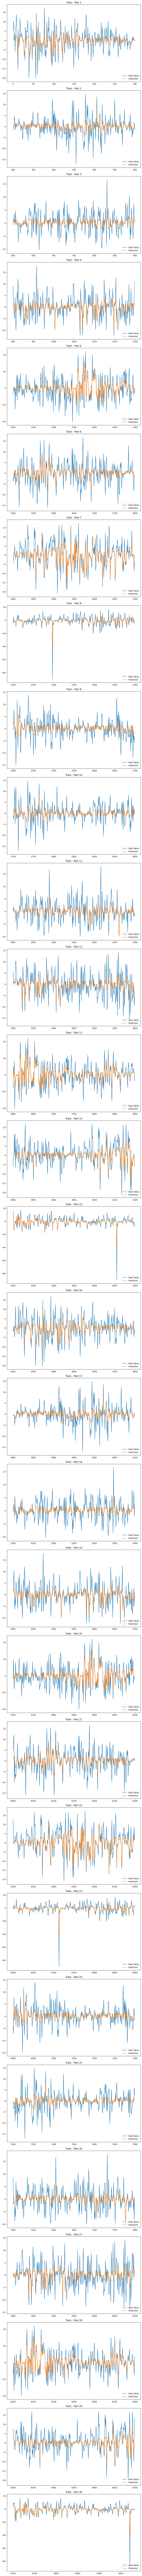

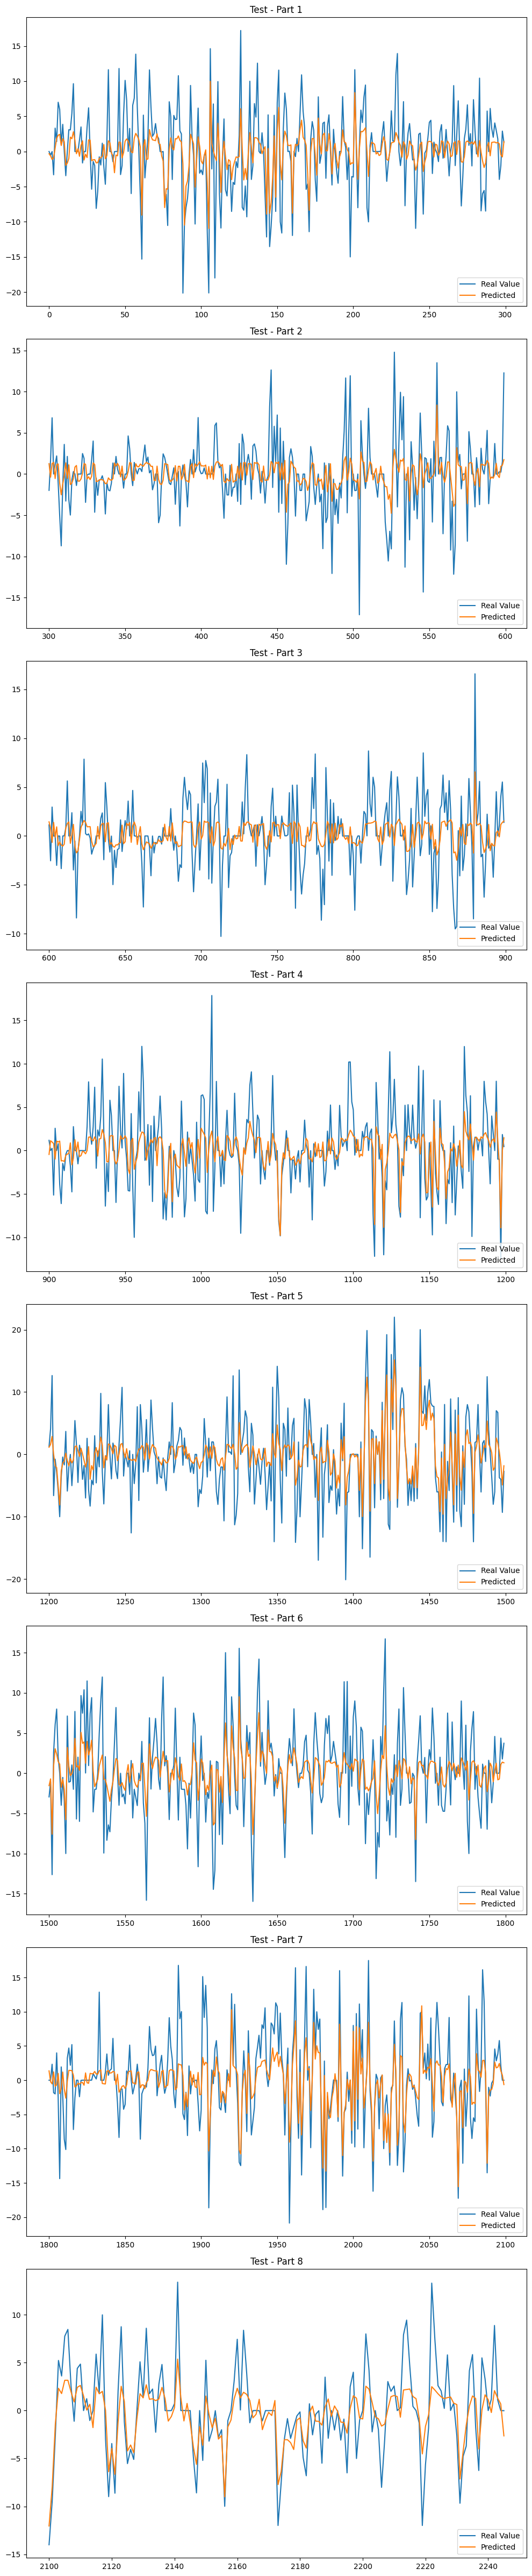

In [513]:
visualization('Train', train_df, train_prediction_df)
visualization('Test', test_df, test_prediction_df)

In [514]:
def evaluate(metric, metric_name, true_values, predicted_values):
    print(f'{metric_name} : {metric(true_values, predicted_values)}')

In [515]:
def evaluation(model_name, train_data, test_data, train_prediction_df, test_prediction_df):
    print(f'{model_name} train scores:')

    evaluate(mean_absolute_error, 'MAE', train_data['target'], train_prediction_df)
    evaluate(mean_squared_error, 'MSE', train_data['target'], train_prediction_df)
    evaluate(mean_absolute_percentage_error, 'MAPE', train_data['target'], train_prediction_df)

    print(f'\n{model_name} test scores:')

    evaluate(mean_absolute_error, 'MAE', test_data['target'], test_prediction_df)
    evaluate(mean_squared_error, 'MSE', test_data['target'], test_prediction_df)
    evaluate(mean_absolute_percentage_error, 'MAPE', test_data['target'], test_prediction_df)


In [516]:
evaluation('Ridge Regression', train_df, test_df, train_prediction_df, test_prediction_df)

Ridge Regression train scores:
MAE : 2.7711946488784864
MSE : 14.821785764321207
MAPE : 317332217848753.6

Ridge Regression test scores:
MAE : 2.7591274292354897
MSE : 13.920263798902527
MAPE : 316026327653636.0


In [517]:
train_df['signal'] = (train_df['target'] > 0).apply(lambda x: int(x))
test_df['signal'] = (test_df['target'] > 0).apply(lambda x: int(x))

C:\Users\bardia\AppData\Local\Temp\ipykernel_26176\85257917.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df['signal'] = (train_df['target'] > 0).apply(lambda x: int(x))
C:\Users\bardia\AppData\Local\Temp\ipykernel_26176\85257917.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df['signal'] = (test_df['target'] > 0).apply(lambda x: int(x))


In [518]:
train_df['predicted_signal'] = (train_prediction_df > 0).astype(int)
test_df['predicted_signal'] = (test_prediction_df > 0).astype(int)

C:\Users\bardia\AppData\Local\Temp\ipykernel_26176\1709710212.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df['predicted_signal'] = (train_prediction_df > 0).astype(int)
C:\Users\bardia\AppData\Local\Temp\ipykernel_26176\1709710212.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df['predicted_signal'] = (test_prediction_df > 0).astype(int)


In [524]:
print(precision_score(train_df['signal'], train_df['predicted_signal']))
print(precision_score(test_df['signal'], test_df['predicted_signal']))

print(accuracy_score(train_df['signal'], train_df['predicted_signal']))
print(accuracy_score(test_df['signal'], test_df['predicted_signal']))

0.688860705981822
0.6891322662173547
0.7334966046977625
0.7328584149599288


C:\Users\bardia\AppData\Local\Temp\ipykernel_26176\3330557461.py:4: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlation_matrix = train_df.corr()


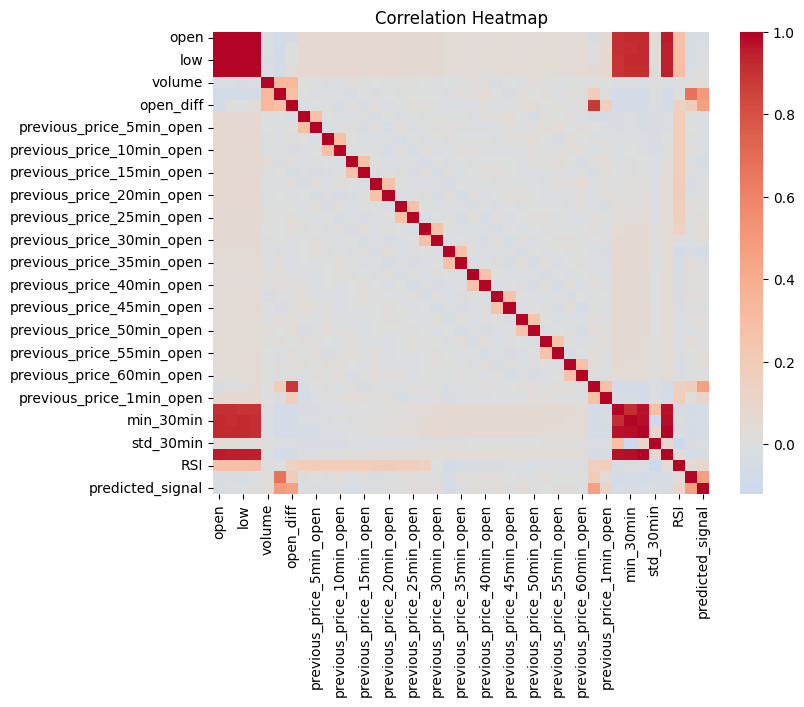

In [520]:
import seaborn as sns

# Calculate the correlation matrix
correlation_matrix = train_df.corr()

# Create a heatmap using seaborn
plt.figure(figsize=(8, 6))  # Adjust the figure size as needed
sns.heatmap(correlation_matrix, cmap='coolwarm', center=0)
plt.title('Correlation Heatmap')
plt.show()